# AUTUMN School groupwork: A Case Study of an electric car

In [2]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc

In [12]:
#Importing existing project

bi.backup.restore_project_directory(
     fp= r'C:\AUTUMN SCHOOL\GIT\autumn-school-work-group\brightway2-project-autumn_school_project_2-backup.14-November-2024-07-46PM.tar.gz',
     project_name='autumn_school_project_EV')

Restoring project backup archive - this could take a few minutes...


ValueError: Project autumn_school_project_EV already exists

In [3]:
bd.projects.set_current(name='autumn_school_project_EV')

In [4]:
bd.projects.current

'autumn_school_project_EV'

## Resources

- *premise* documentation: https://github.com/polca/premise/tree/master
- *ODYM* documentation: https://github.com/IndEcol/ODYM

Many of the concepts here and inspiration for the exercise material are drawn from the lectures by Niko Heeren at ETH Zurich.

# 1. Combining MFA and LCA

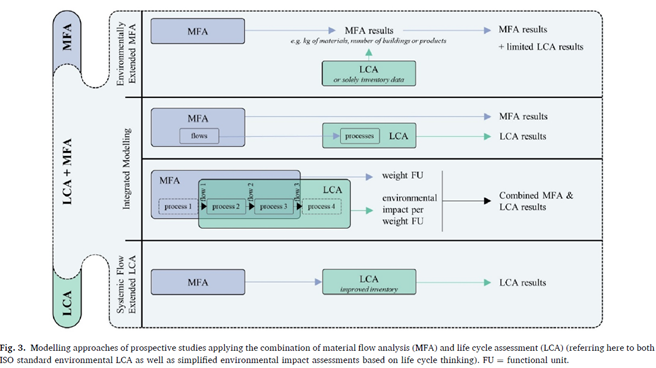

1. Barkhausen, R., Rostek, L., Miao, Z. C., & Zeller, V. (2023). Combinations of material flow analysis and life cycle assessment and their applicability to assess circular economy requirements in EU product regulations. A systematic literature review. Journal of Cleaner Production, 137017.  https://doi.org/10.1016/j.jclepro.2023.137017

# 2. Key MFA concepts

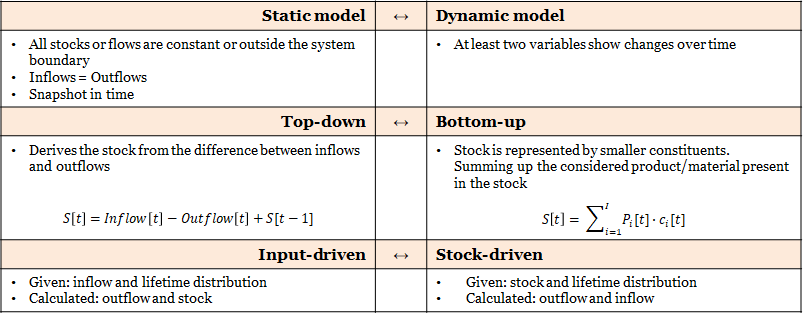

# 3. Case study: PV energy Demand Scenarios

**# Objective**: Analyze material requirements and environmental impacts for two distinct PV energy demand scenarios, focusing on the stock, inflows, outflows, and recycling potential of PV modules.

#### **3.0. Load and Process Energy Demand Data**

1. **Objective**: Load PV energy demand data for the given region (RER) and two scenarios from an external CSV file.
1. **Deliverable**: A plot of PV energy demand over time for both scenarios.


#### **3.1. Stock of PV Modules (*premise*)**
1. **Objective**: Using *premise*, determine the stock of PV modules required to meet projected PV energy demands from now until 2100.
1. **Deliverable**: A plot showing the cumulative stock of PV modules over time for both scenarios.

#### **3.2. Inflows and Outflows (*ODYM*)**
1. **Objective**: Using ODYM, determine the inflows and outflows of PV modules over time.
1. **Instructions**:
   - Since this exercise assumes no past solar installations, focus solely on new installations from today onwards.
   - Apply a convolution method to reflect lifetime distribution to simulate the module turnover.
1. **Deliverable**: Plots for inflow and outflow of PV modules, distinguishing between scenarios.

#### **3.3. Environmental Impact Assessment (Modular LCA)**
1. **Objective**: Calculate the environmental impacts of both scenarios following a modular LCA approach.
2. **Instructions**:
   - Use environmental characterization factors to evaluate impacts (e.g., GHG emissions, resource depletion).
   - Focus on the main environmental impacts and discuss the potential trade-offs of each scenario.
3. **Deliverable**: A summary table of key environmental impacts for each scenario, accompanied by a brief interpretation of results.

## 3.0. Load and Process Energy Demand Data

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We start importing the annual km needed under each scenario

In [42]:
transport_demand_df = pd.read_csv('Germany_transport_2050.csv')
transport_demand_df.head()

,Year,SSP1-pkm,SSP2-pkm,LED-pkm
0,2024,8.482033e+11,9.076077e+11,8.082948e+11
1,2025,8.462325e+11,9.121966e+11,8.019172e+11
2,2026,8.443007e+11,9.168194e+11,7.955819e+11
3,2027,8.423695e+11,9.214351e+11,7.892524e+11
4,2028,8.404170e+11,9.260195e+11,7.829083e+11


Let's visualize it

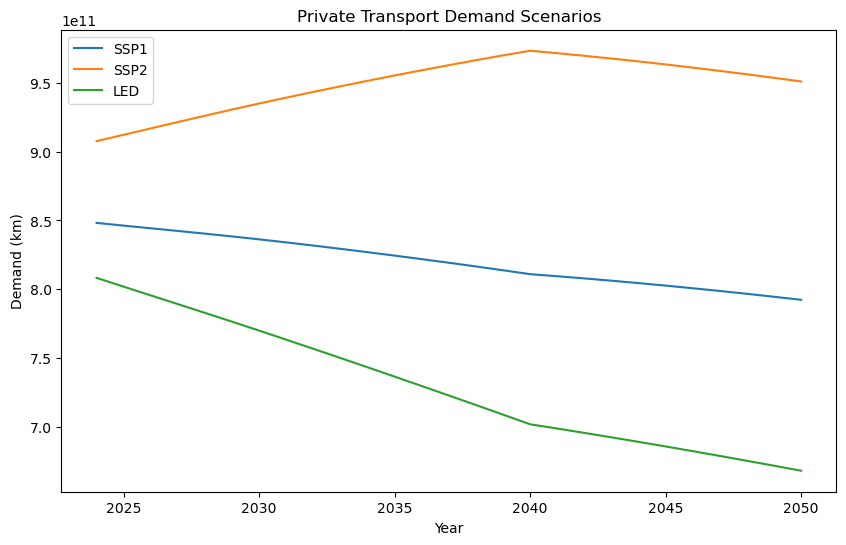

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(transport_demand_df['Year'], transport_demand_df['SSP1-pkm'], label='SSP1')
plt.plot(transport_demand_df['Year'], transport_demand_df['SSP2-pkm'], label='SSP2')
plt.plot(transport_demand_df['Year'], transport_demand_df['LED-pkm'], label='LED')
plt.xlabel('Year')
plt.ylabel('Demand (km)')
plt.title('Private Transport Demand Scenarios')
plt.legend()
plt.show()

## 3.1. Stock Electric cars

We assume all the PV energy demand is satisfied by "electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, laminated, integrated [CH]". Next, we retrieve the total "photovoltaic module production, building-integrated, for slanted-roof installation [RER]" needed in stock.

In [18]:
# import bw2io as bi
# import bw2data as bd
# import bw2calc as bc

In [45]:
from tqdm import tqdm
from scipy.interpolate import interp1d

In [46]:
# bd.projects.copy_project(name='group-work')

In [47]:
# bd.projects.set_current(name='autumn_school_project_EV')
bd.databases

Databases dictionary with 11 object(s):
	biosphere3
	ecoinvent-3.10-cutoff
	ei_cutoff_3.10_image_SSP1-Base_2020 2024-11-14
	ei_cutoff_3.10_image_SSP1-Base_2050 2024-11-14
	ei_cutoff_3.10_image_SSP2-RCP19_2020 2024-11-14
	ei_cutoff_3.10_image_SSP2-RCP19_2050 2024-11-14
	ei_cutoff_3.10_remind_SSP1-PkBudg500_2020 2024-11-14
	ei_cutoff_3.10_remind_SSP1-PkBudg500_2050 2024-11-14
	ei_cutoff_3.10_remind_SSP2-PkBudg500_2020 2024-11-14
	ei_cutoff_3.10_remind_SSP2-PkBudg500_2050 2024-11-14
	super_db_14-11-2024

In [48]:
base_db = { 
    2020:'ei_cutoff_3.10_remind_SSP1-PkBudg500_2020 2024-11-14',
    2050:'ei_cutoff_3.10_remind_SSP1-PkBudg500_2050 2024-11-14',
}
SSP2_db = {
    2020:'ei_cutoff_3.10_remind_SSP2-PkBudg500_2020 2024-11-14',
    2050:'ei_cutoff_3.10_remind_SSP2-PkBudg500_2050 2024-11-14',
}
LED_db = {
    2020:'ei_cutoff_3.10_remind_SSP2-PkBudg500_2020 2024-11-14',
    2050:'ei_cutoff_3.10_remind_SSP2-PkBudg500_2050 2024-11-14',
}

We will be interpolating based on existing databases in our project. In my case, I built databases in intervals of 5 years. I decided to match Scenario 1 to REMIND-SSP2-Base; and Scenario 2 to REMIND-SSP2-PkBudg1150.

In [49]:
def calculate_ev_transport(year, scenario):
    # if scenario == "Base":
    #     database_name = base_db[year]

    # else if 
    #     database_name = SSP2_db[year]
    # else:
    #     database_name = LED_db[year]
    if scenario == "SSP1":
        database_name = base_db[year]
    elif scenario == "SSP2":
        database_name = SSP2_db[year]
    else: 
        database_name = LED_db[year]

    
    
    
    
    #database_name = f'ei_cutoff_3.10_remind_SSP2-{scenario}_{year} 2024-11-05' # Update to match the name of your databases

    ### Define functional unit ###
    act_ev_transport = [act for act in bd.Database(database_name)
            if 'transport, passenger car, electric' in act['name']
           and 'market' in act['name']
           and 'GLO' in act['location']
           ][0]
    functional_unit = {act_ev_transport: 1}  # 1 km
    
    ### Run LCA ###
    lca = bc.LCA(functional_unit)
    lca.lci()

    ### Find EV module amount ###
    act_ev_production = [act for act in bd.Database(database_name)
           #  if 'passenger car production' in act['name']
           # and 'electric' in act['name']
           # and 'GLO' in act['location']
           # ][0]
            if 'market for glider' in act['name']
           and 'passenger car' in act['name']
           and 'GLO' in act['location']
           ][0]
    lca_value = lca.supply_array[lca.activity_dict[act_ev_production.key]]

    return lca_value

In [50]:
ev_transport_values = {
    'Year': [],
    'EV transport - Baseline Scenario': [],
    'EV transport - SSP2': [],
    'EV transport - LED': []
}

In [51]:
for year, db_name in tqdm(base_db.items()):
    # Calculate EV intensity for Baseline
    baseline_intensity = calculate_ev_transport(year, scenario='SSP1')
    # Calculate EV intensity for SSP2
    SSP2_db_intensity = calculate_ev_transport(year, scenario='SSP2')
    # Calculate EV intensity for LED
    LED_db_intensity = calculate_ev_transport(year, scenario='LED')

    # Store results
    ev_transport_values['Year'].append(year)
    ev_transport_values['EV transport - Baseline Scenario'].append(baseline_intensity)
    ev_transport_values['EV transport - SSP2'].append(SSP2_db_intensity)
    ev_transport_values['EV transport - LED'].append(LED_db_intensity)
    

ev_transport_df = pd.DataFrame(ev_transport_values)
ev_transport_df 

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:54<00:00, 27.29s/it]


,Year,EV transport - Baseline Scenario,EV transport - SSP2,EV transport - LED
0,2020,0.005587,0.005587,0.005587
1,2050,0.005587,0.005587,0.005587


For Scenario 2, we anticipate that the efficiency of individual PV installations (in terms of kWh/m²) will improve faster than in Scenario 1. However, despite these improvements, we observe a higher intensity increase in Scenario 2. This is due to our consideration of the entire supply chain. In the PkBudg1150 scenario, a greater volume of PV is deployed, which in turn increases upstream PV demand — resulting in an even higher demand for PV modules throughout the supply chain.

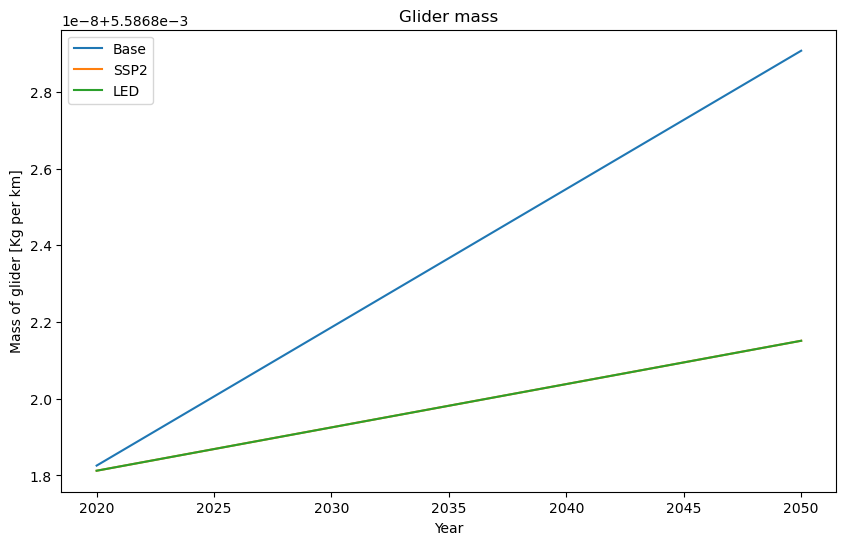

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(ev_transport_df['Year'], ev_transport_df['EV transport - Baseline Scenario'], label='Base')
plt.plot(ev_transport_df['Year'], ev_transport_df['EV transport - SSP2'], label='SSP2')
plt.plot(ev_transport_df['Year'], ev_transport_df['EV transport - LED'], label='LED')
plt.xlabel('Year')
plt.ylabel('Mass of glider [Kg per km]')
plt.title('Glider mass')
plt.legend()
plt.show()

In [53]:
# Interpolate to get values for each year between 2025 and 2060
all_years = np.arange(2025, 2051)
SSP1_interp = interp1d(ev_transport_df['Year'], ev_transport_df['EV transport - Baseline Scenario'], kind='linear', fill_value="extrapolate")
SSP2_interp = interp1d(ev_transport_df['Year'], ev_transport_df['EV transport - SSP2'], kind='linear', fill_value="extrapolate")
LED_interp = interp1d(ev_transport_df['Year'], ev_transport_df['EV transport - LED'], kind='linear', fill_value="extrapolate")

interpolated_ev_transport_df = pd.DataFrame({
    'Year': all_years,
    'EV transport - Baseline Scenario': SSP1_interp(all_years),
    'EV transport - SSP2': SSP2_interp(all_years),
    'EV transport - LED': LED_interp(all_years)
})

In [54]:
ev_glider_df = pd.merge(transport_demand_df, interpolated_ev_transport_df, on='Year')
ev_glider_df['Total mass glider - SSP1 (kg)'] = ev_glider_df['SSP1-pkm'] * ev_glider_df['EV transport - Baseline Scenario']
ev_glider_df['Total mass glider - SSP2 (kg)'] = ev_glider_df['SSP2-pkm'] * ev_glider_df['EV transport - SSP2']
ev_glider_df['Total mass glider - LED (kg)'] = ev_glider_df['LED-pkm'] * ev_glider_df['EV transport - LED']

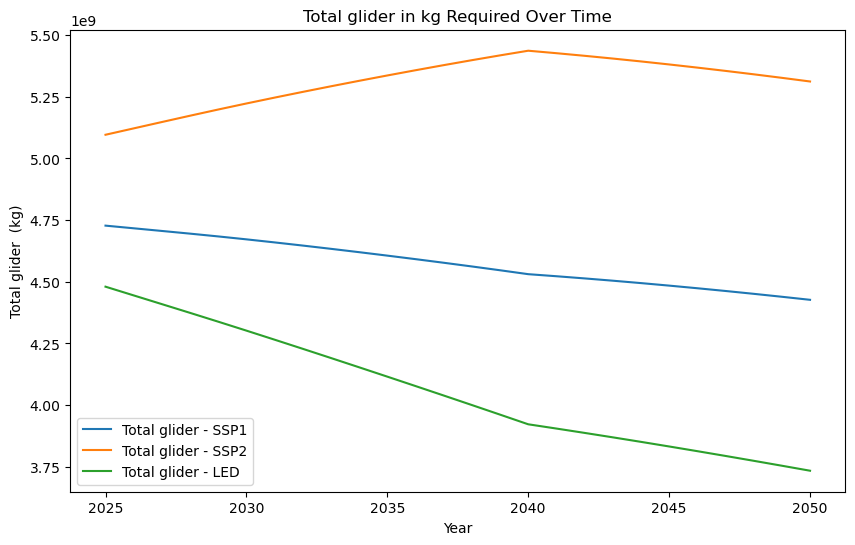

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(ev_glider_df['Year'], ev_glider_df['Total mass glider - SSP1 (kg)'], label='Total glider - SSP1')
plt.plot(ev_glider_df['Year'], ev_glider_df['Total mass glider - SSP2 (kg)'], label='Total glider - SSP2')
plt.plot(ev_glider_df['Year'], ev_glider_df['Total mass glider - LED (kg)'], label='Total glider - LED')
plt.xlabel('Year')
plt.ylabel('Total glider  (kg)')
plt.title('Total glider in kg Required Over Time')
plt.legend()
plt.show()

Let's take a look at how the **total PV module area** and **total energy demand** change over time for each scenario. 

This plot shows:
- **Total Area (left y-axis)**: the cumulative PV module area needed (in m²) to meet projected energy demand in each scenario.
- **Energy Demand (right y-axis)**: the expected energy demand (in TWh/a), plotted with dashed lines.

By visualizing these two metrics together, we can see how closely the area requirements track with energy demand and identify any gaps between the two over time.


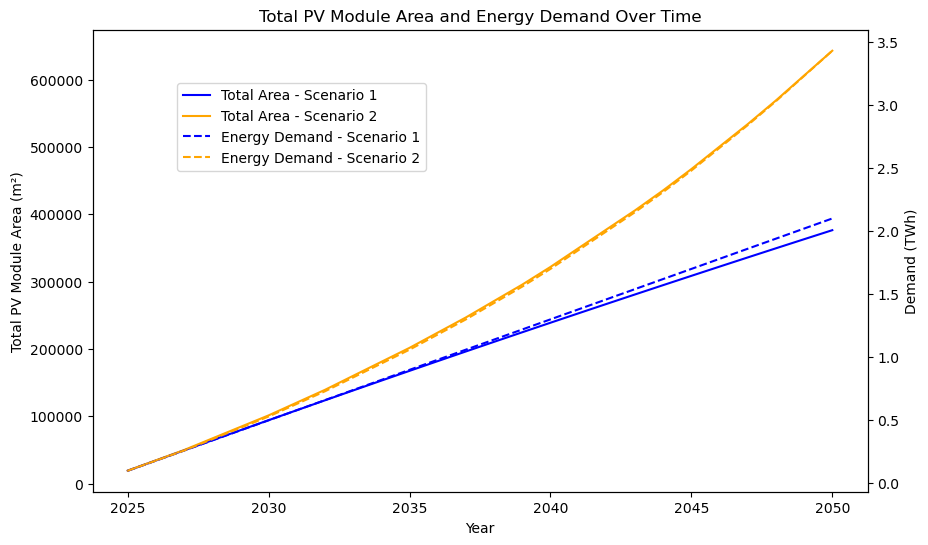

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(pv_area_df['Year'], pv_area_df['Total area - Scenario 1 (m²)'], label='Total Area - Scenario 1', color='blue')
ax1.plot(pv_area_df['Year'], pv_area_df['Total area - Scenario 2 (m²)'], label='Total Area - Scenario 2', color='orange')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total PV Module Area (m²)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Total PV Module Area and Energy Demand Over Time')

ax2 = ax1.twinx()
ax2.plot(energy_demand_df['Year'], energy_demand_df['Scenario 1 - Solar production [TWh/a]'], label='Energy Demand - Scenario 1', linestyle='--', color='blue')
ax2.plot(energy_demand_df['Year'], energy_demand_df['Scenario 2 - Solar production [TWh/a]'], label='Energy Demand - Scenario 2', linestyle='--', color='orange')
ax2.set_ylabel('Demand (TWh)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends for both y-axes
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)
plt.show()


## 3.2. Inflows and Outflows (*ODYM*)

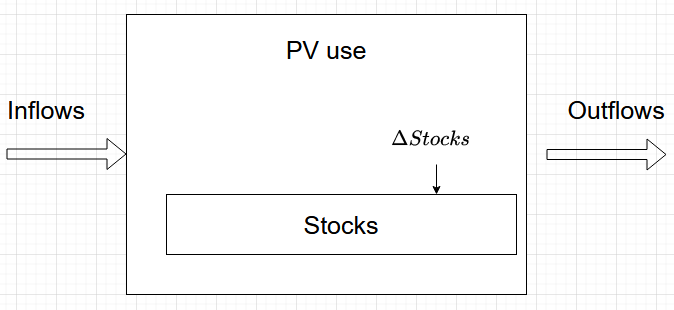

### 3.2.1) Load ODYM

In [26]:
from odym import ODYM_Classes as msc
from odym import ODYM_Functions as msf
from odym import dynamic_stock_model as dsm 

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pylab

### 3.2.2) Define your MFA system

We start by defining the time scope and the various dimensions of our system, such as time, elements, and scenarios.

In [28]:
ModelClassification  = {} # Create dictionary of model classifications

MyYears_2050 = list(np.arange(2025,2051)) # Data are present for years 2025-2050
# MyYears_2121 = list(np.arange(2025,2122)) # We can expand up to 2121 to evaluate the stock disipation

In [29]:
# Classification for time labelled 'Time' must always be present, with Items containing a list of odered integers representing years, months, or other discrete time intervals
ModelClassification['Time'] = msc.Classification(Name = 'Time',
                                                 Dimension = 'Time',
                                                 ID = 1,
                                                 Items = MyYears_2050
                                                )

In [30]:
# Classification for cohort is used to track age-cohorts in the stock.
ModelClassification['Cohort'] = msc.Classification(Name = 'Age-cohort',
                                                   Dimension = 'Time',
                                                   ID = 2,
                                                   Items = MyYears_2050
                                                  )

In [31]:
# Classification for elements labelled 'Element' must always be present, with Items containing a list of the symbols of the elements covered.
ModelClassification['Element'] = msc.Classification(Name = 'Elements',
                                                    Dimension = 'Element', 
                                                    ID = 3,
                                                    Items = ['PV modules']
                                                   )

In [32]:
MyScenarios = ['Scenario 1', 'Scenario 2']
ModelClassification['Scenario'] = msc.Classification(Name = 'Scenarios',
                                                     Dimension = 'Scenario',
                                                     ID = 4,
                                                     Items = MyScenarios
                                                    )

In [33]:
# Get model time start, end, and duration:
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start

In [34]:
IndexTable = pd.DataFrame({'Aspect'        : ['Time','Age-cohort','Element','Scenario'], # 'Time' and 'Element' must be present!
                           'Description'   : ['Model aspect "time"','Model aspect "age-cohort"', 'Model aspect "Element"','Model aspect "Scenario"'],
                           'Dimension'     : ['Time','Time','Element','Scenario'], # 'Time' and 'Element' are also dimensions
                           'Classification': [ModelClassification[Aspect] for Aspect in ['Time','Cohort','Element','Scenario']],
                           'IndexLetter'   : ['t','c','e','s']}) # Unique one letter (upper or lower case) indices to be used later for calculations.

IndexTable.set_index('Aspect', inplace = True) # Default indexing of IndexTable, other indices are produced on the fly
IndexTable

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<odym.ODYM_Classes.Classification object at 0x...,t
Age-cohort,"Model aspect ""age-cohort""",Time,<odym.ODYM_Classes.Classification object at 0x...,c
Element,"Model aspect ""Element""",Element,<odym.ODYM_Classes.Classification object at 0x...,e
Scenario,"Model aspect ""Scenario""",Scenario,<odym.ODYM_Classes.Classification object at 0x...,s


In [35]:
Dyn_MFA_System = msc.MFAsystem(Name = 'TestSystem', 
                      Geogr_Scope = 'TestRegion', 
                      Unit = 'unit', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = {}, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

### 3.2.3) Inserting data into the MFA system

#### Processes

We define the processes in our system: "PV in use" and the rest of the system/economy, as shown in the diagram.

In [36]:
Dyn_MFA_System.ProcessList = [] # Start with empty process list, only process numbers (IDs) and names are needed.
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'Other industries', ID   = 0))
Dyn_MFA_System.ProcessList.append(msc.Process(Name = 'PV in use'  , ID   = 1))

# Print list of processes:
Dyn_MFA_System.ProcessList

#### Life time

In this analysis, we will assume a Weibull distribution for the PV module lifetimes. The primary advantage of the Weibull distribution is that it does not allow for negative values, which helps ensure an accurate mass balance. To define the distribution, we need two parameters: the lifetime (average lifespan of PV modules) and the shape parameter (which influences the spread and skewness of the distribution).

In [37]:
### Time to input the life time of PVs
Lifetime = [30]
Shape = [5.38]

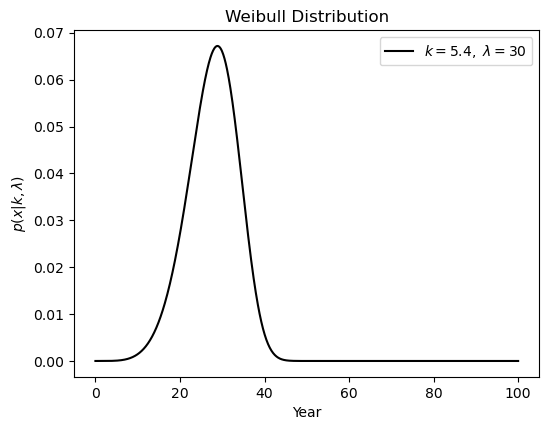

In [38]:
from scipy.stats import weibull_min
#------------------------------------------------------------
# plot the distributions
x = np.linspace(0, 100, 1000)
fig, ax = plt.subplots(figsize=(6, 4.5))


dist = weibull_min(Shape[0], 0, Lifetime[0])
plt.plot(x, dist.pdf(x), c='black',
         label=r'$k=%.1f,\ \lambda=%i$' % (Shape[0], Lifetime[0]))

plt.xlabel('Year')
plt.ylabel(r'$p(x|k,\lambda)$')
plt.title('Weibull Distribution')

plt.legend()
plt.show()

#### Flows

After defining our processes, we need to set up the flows.

In [39]:
# Initialize StockArray with the correct shape (Scenarios x Years)
StockArray = np.zeros((len(MyScenarios), len(MyYears_2050)))

# Fill StockArray with PV area demands for each scenario
StockArray[0, :] = pv_area_df['Total area - Scenario 1 (m²)'].values
StockArray[1, :] = pv_area_df['Total area - Scenario 2 (m²)'].values

In [40]:
ParameterDict = {}

#
ParameterDict['Stock']= msc.Parameter(Name = 'PV demand', ID = 1, P_Res = 1,
                                       MetaData = None, Indices = 's,t', 
                                      Values = StockArray, Unit = 'kt/yr')

#
ParameterDict['eta']   = msc.Parameter(Name = 'mean product lifetime', ID = 2, P_Res = 1, 
                                       MetaData = None, 
                                       Values = Lifetime, Unit = 'yr')
ParameterDict['beta'] = msc.Parameter(Name = 'Shape parameter', ID = 3, P_Res = 1,
                                       MetaData = None, 
                                       Values = Shape, Unit = 'yr')

# Assign parameter dictionary to MFA system:
Dyn_MFA_System.ParameterDict = ParameterDict

In [41]:
# Define the flows of the system, and initialise their values:
Dyn_MFA_System.FlowDict['F_0_1'] = msc.Flow(Name = 'final consumption', P_Start = 0, P_End = 1,
                                            Indices = 't,s,e', Values=None)
Dyn_MFA_System.FlowDict['F_1_0'] = msc.Flow(Name = 'Eol products', P_Start = 1, P_End = 0,
                                            Indices = 't,c,s,e', Values=None)
Dyn_MFA_System.StockDict['S_1']   = msc.Stock(Name = 'PV stock', P_Res = 1, Type = 0,
                                              Indices = 't,c,s,e', Values=None)
Dyn_MFA_System.StockDict['dS_1']  = msc.Stock(Name = 'PV stock change', P_Res = 1, Type = 1,
                                              Indices = 't,s,e', Values=None)

Dyn_MFA_System.Initialize_FlowValues() # Assign empty arrays to flows according to dimensions.
Dyn_MFA_System.Initialize_StockValues() # Assign empty arrays to flows according to dimensions.

In [42]:
# Check whether flow value arrays match their indices, etc. See method documentation.
Dyn_MFA_System.Consistency_Check() 

(True, True, True)

### 3.2.4) Programming a solution of the MFA system & Balance Check

With all elements defined, we’re ready to solve the system.

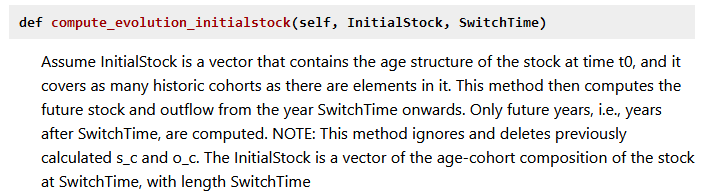

In [43]:
age_cohort = np.zeros((len(MyScenarios), len(MyYears_2050), len(MyYears_2050))) ### Scenario x (Year x Age cohort)
O_C = np.zeros((len(MyScenarios), len(MyYears_2050), len(MyYears_2050)))
I_C = np.zeros((len(MyScenarios), len(MyYears_2050), len(MyYears_2050)))

Stock_by_cohort_evol = np.zeros((len(MyScenarios), len(MyYears_2050), len(MyYears_2050)))

In [44]:
for scenario in np.arange(0,len(MyScenarios)): # from the first region (index 0) to the last region (Python does not use the last index on the right side of an interval)
    # Create helper DSM for computing the dynamic stock model:
    DSM_Stock = dsm.DynamicStockModel(t = np.array(MyYears_2050),
                                      s = Dyn_MFA_System.ParameterDict['Stock'].Values[scenario,:], 
                                      lt = {
                                             'Type': 'Weibull', 
                                             'Scale': Dyn_MFA_System.ParameterDict['eta'].Values,
                                             'Shape': Dyn_MFA_System.ParameterDict['beta'].Values,
                                            }
                                      )
    #### Solve the system for 2025-2050
    age_cohort[scenario,:,:], O_C[scenario,:,:], I_C[scenario,:,:] = DSM_Stock.compute_stock_driven_model()
    
    
    Dyn_MFA_System.StockDict['S_1'].Values[0:len(MyYears_2050),:,scenario,0] = age_cohort[scenario,0:len(MyYears_2050),:]
    Dyn_MFA_System.FlowDict['F_0_1'].Values[0:len(MyYears_2050),scenario,0] = I_C[scenario,0,0:len(MyYears_2050)]
    Dyn_MFA_System.FlowDict['F_1_0'].Values[0:len(MyYears_2050),:,scenario,0] = O_C[scenario,0:len(MyYears_2050),:]
    DS = DSM_Stock.compute_stock_change()
    Dyn_MFA_System.StockDict['dS_1'].Values[0:len(MyYears_2050),scenario,0] = DS[0:len(MyYears_2050)]
    
    print('-------------------- SCENARIO_%d --------------------' %(scenario+1))
    Bal = Dyn_MFA_System.MassBalance()
    print('Dimensions of balance are: time step x process x chemical element')
    print(Bal.shape) # dimensions of balance are: time step x process x chemical element
    print('Sum of all absolute balancing errors by process.')
    print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

-------------------- SCENARIO_1 --------------------
Dimensions of balance are: time step x process x chemical element
(26, 2, 1)
Sum of all absolute balancing errors by process.
[[4.18367563e-10]
 [4.18367563e-10]]
-------------------- SCENARIO_2 --------------------
Dimensions of balance are: time step x process x chemical element
(26, 2, 1)
Sum of all absolute balancing errors by process.
[[6.33008312e-10]
 [6.33008312e-10]]


### 3.2.5) Results visualization

In [45]:
flow_data = Dyn_MFA_System.StockDict['S_1'].Values[:,:,0,0].sum(axis =1)
flow_df = pd.DataFrame(flow_data, columns=[f"Flow_Scenario"])  # Name the column based on the scenario index

# Save the DataFrame to Excel
flow_df.to_excel("flow_data_scenario_m.xlsx", index=False)

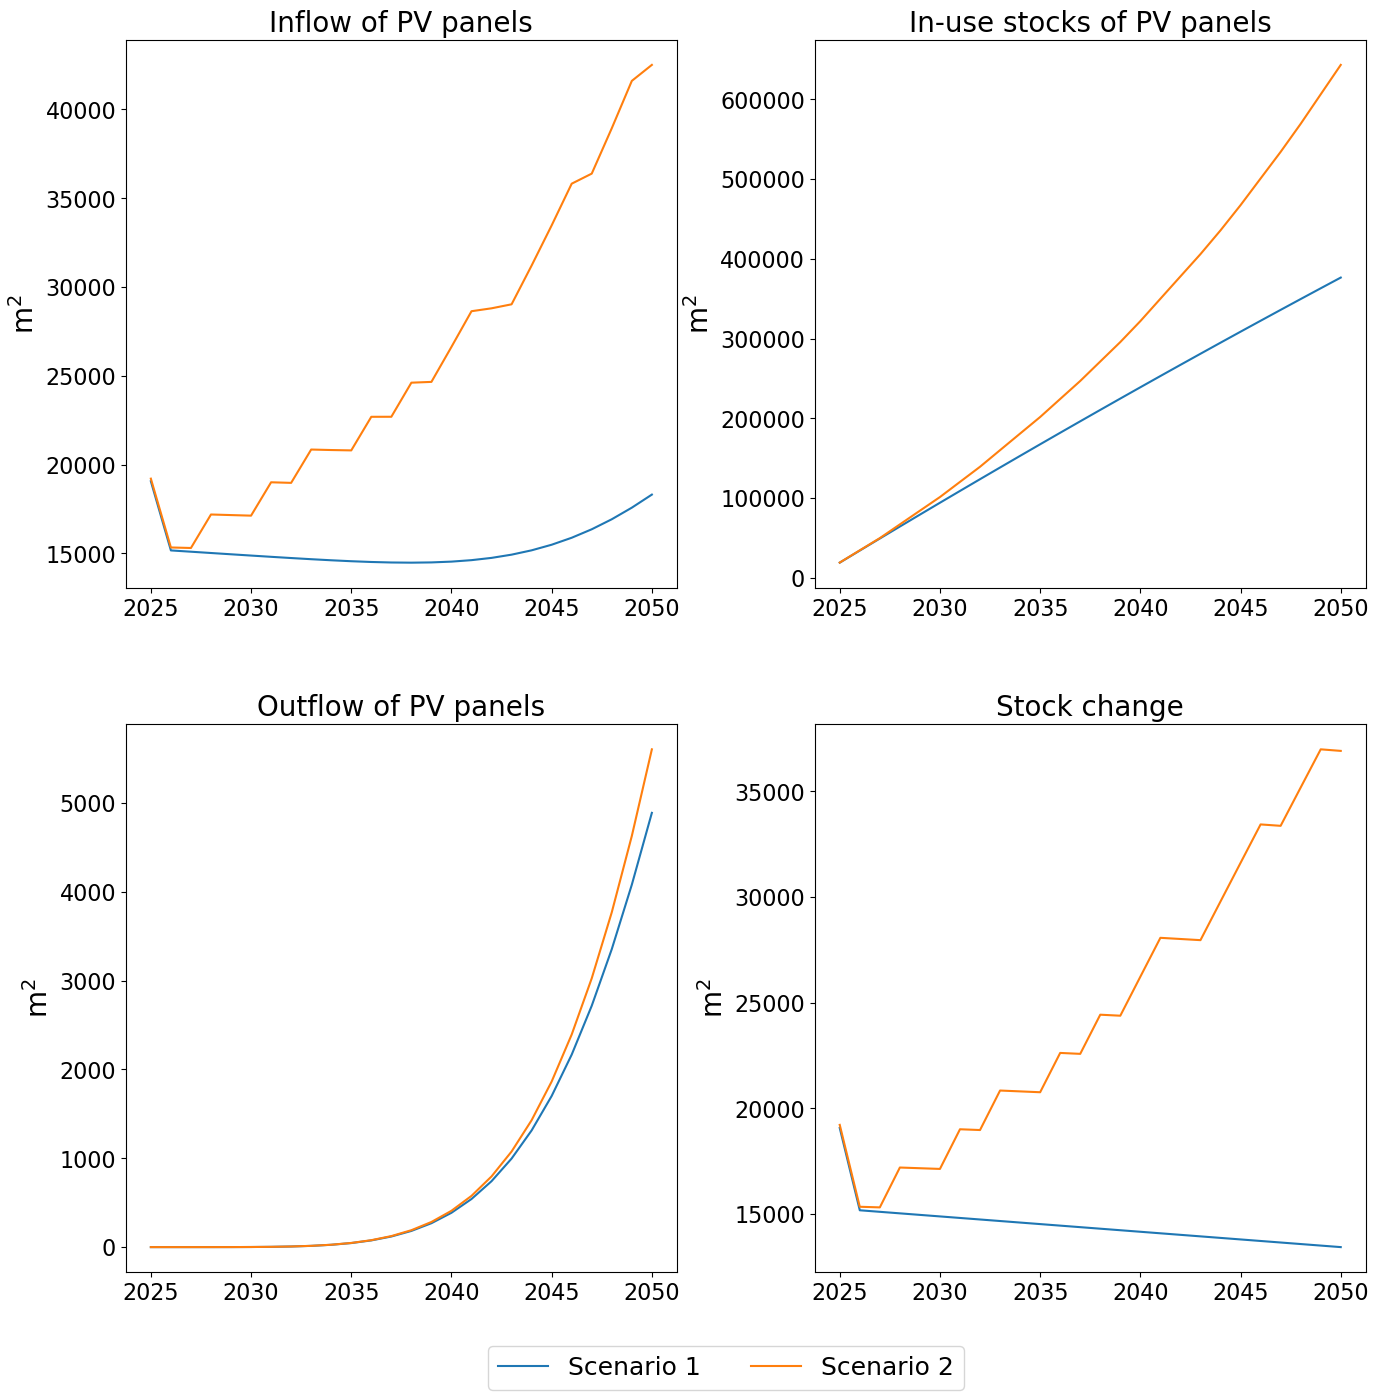

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
MyColorCycle = pylab.cm.tab10(np.arange(0,1,0.1)) # select 10 colors from the 'tab10' color map.

# plot the data and set titles
for m in range(0,len(MyScenarios)):
    axs[0,0].plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
                  Dyn_MFA_System.FlowDict['F_0_1'].Values[:,m,0], 
                  color = MyColorCycle[m,:])
    axs[0, 1].plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
                       Dyn_MFA_System.StockDict['S_1'].Values[:,:,m,0].sum(axis =1), 
                   color = MyColorCycle[m,:])
    axs[1, 0].plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
                   Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,m,0].sum(axis =1), 
                   color = MyColorCycle[m,:])
    axs[1, 1].plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
                   Dyn_MFA_System.StockDict['dS_1'].Values[:,m,0], 
                   color = MyColorCycle[m,:])

# add subplot titles
axs[0, 0].set_title('Inflow of PV panels', fontsize=20)
axs[0, 1].set_title('In-use stocks of PV panels', fontsize=20)
axs[1, 0].set_title('Outflow of PV panels', fontsize=20)
axs[1, 1].set_title('Stock change', fontsize=20)

# format ticks font size
axs[0, 0].tick_params(axis='both', which='major', labelsize=16)  
axs[0, 1].tick_params(axis='both', which='major', labelsize=16)
axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
axs[1, 1].tick_params(axis='both', which='major', labelsize=16) 

# add y-axis titles
axs[0, 0].set_ylabel('m$^2$',fontsize =20)
axs[0, 1].set_ylabel('m$^2$',fontsize =20)
axs[1, 0].set_ylabel('m$^2$',fontsize =20)
axs[1, 1].set_ylabel('m$^2$',fontsize =20)
    
# Adjust the spacing of the subplots and legend
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Add the legend to the legend subplot
fig.legend(MyScenarios, loc='center', bbox_to_anchor=(0.5, 0.05), ncol=len(MyScenarios), prop={'size': 18})

# save figure
# fig.savefig('MFA_viz.png',  bbox_inches='tight',format='png', dpi=300)

Plotting the output-to-input ratio helps assess recycling potential. A ratio of 100% indicates output equals input, meaning total input could theoretically be sourced from recycling. Lower ratios imply a lower maximum potential recycling rate.

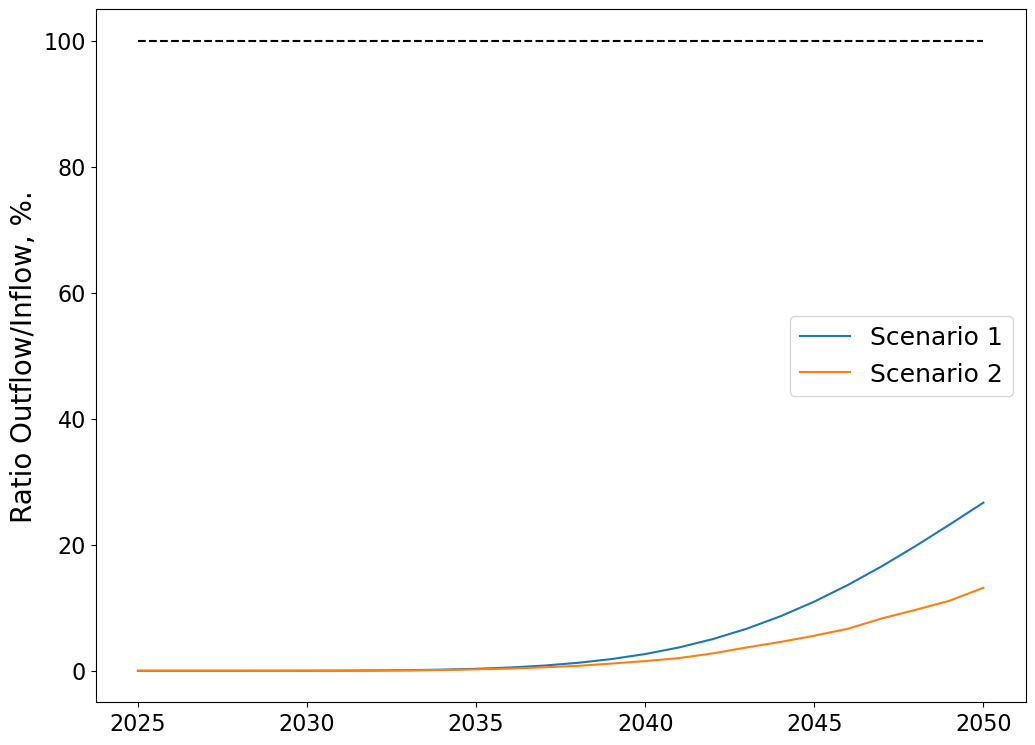

In [47]:
FlowRatio = (Dyn_MFA_System.FlowDict['F_1_0'].Values[:,:,:,0].sum(axis =1) / 
             Dyn_MFA_System.FlowDict['F_0_1'].Values[:,:,0])

fig, ax = plt.subplots(figsize=(12, 9))
for m in range(0,len(MyScenarios)):
    ax.plot(Dyn_MFA_System.IndexTable['Classification']['Time'].Items, 
            FlowRatio[:,m] * 100, color = MyColorCycle[m,:])
ax.plot([2025,2050],[100,100], color = 'k',linestyle = '--')
ax.set_ylabel('Ratio Outflow/Inflow, %.',fontsize =20)
ax.legend(MyScenarios, loc='best',prop={'size':18})
ax.tick_params(axis='both', which='major', labelsize=16) 


# fig.savefig('Ratio.png', bbox_inches='tight',format='png', dpi=300)

## 3.3. Environmental Impact Assessment (Modular LCA)

We now apply a modular LCA approach, dividing the system into two modules: production of PV modules and treatment. For each time step, we calculate the environmental impacts of producing and treating inflows and outflows for each scenario.

A good reference for delving deeper into this approach:<br>
Steubing, B., Mutel, C., Suter, F., & Hellweg, S. (2016). Streamlining scenario analysis and optimization of key choices in value chains using a modular LCA approach. The International Journal of Life Cycle Assessment, 21, 510-522. https://link.springer.com/article/10.1007/s11367-015-1015-3

We’ll calculate data points for our existing databases and interpolate for all years. These intensities are then multiplied by the arrays from our MFA.

In [59]:
def calculate_gwp_intensity(year, scenario, activity_name):
    if scenario == "Base":
        database_name = base_db [year]

    else:  
        database_name = pkbudg1150_db [year]
    #database_name = f'ei_cutoff_3.10_remind_SSP2-{scenario}_{year} 2024-11-05'
    
    activity = [act for act in bd.Database(database_name)
               if activity_name in act["name"]
               and 'RER' in act['location']][0]
    functional_unit = {activity:1}

    ### Run LCA for GWP calculation ###
    method = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
    lca = bc.LCA(functional_unit, method)
    lca.lci()
    lca.lcia()
    
    return lca.score

In [60]:
gwp_intensity_values = {
    'Year': [],
    'PV module GWP - Scenario 1': [],
    'Treatment GWP - Scenario 1': [],
    'PV module GWP - Scenario 2': [],
    'Treatment GWP - Scenario 2': []
}

In [61]:
for year, db_name in tqdm(base_db.items()):
    # Calculate GWP for "photovoltaic module production, building-integrated, for slanted-roof installation"
    pv_module_gwp_baseline = calculate_gwp_intensity(year, scenario='Base', activity_name='photovoltaic module production, building-integrated, for slanted-roof installation')
    pv_module_gwp_2degree = calculate_gwp_intensity(year, scenario='PkBudg1150', activity_name='photovoltaic module production, building-integrated, for slanted-roof installation')
    
    # Calculate GWP for "treatment, c-Si PV module"
    treatment_gwp_baseline = calculate_gwp_intensity(year, scenario='Base', activity_name='treatment, c-Si PV module')
    treatment_gwp_2degree = calculate_gwp_intensity(year, scenario='PkBudg1150', activity_name='treatment, c-Si PV module')

    # Store results
    gwp_intensity_values['Year'].append(year)
    gwp_intensity_values['PV module GWP - Scenario 1'].append(pv_module_gwp_baseline)
    gwp_intensity_values['Treatment GWP - Scenario 1'].append(treatment_gwp_baseline)
    gwp_intensity_values['PV module GWP - Scenario 2'].append(pv_module_gwp_2degree)
    gwp_intensity_values['Treatment GWP - Scenario 2'].append(treatment_gwp_2degree)

# Convert to DataFrame
gwp_intensity_df = pd.DataFrame(gwp_intensity_values)
gwp_intensity_df

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:27<00:00, 13.94s/it]


,Year,PV module GWP - Scenario 1,Treatment GWP - Scenario 1,PV module GWP - Scenario 2,Treatment GWP - Scenario 2
0,2020,31.433736,0.269988,33.746455,0.235685
1,2050,21.695756,0.254316,16.693074,0.192509


In [62]:
mass_per_square_meter = 15.2  # kg per m² for PV panels

inflows = Dyn_MFA_System.FlowDict['F_0_1'].Values  # Inflows (m²)
outflows = Dyn_MFA_System.FlowDict['F_1_0'].Values  # Outflows (m²)

In [63]:
# Define a function to get interpolated GWP intensity for a specific year
def get_interpolated_gwp(year, scenario, intensity_type):
    if intensity_type == "production":
        column = f'PV module GWP - {scenario}'
    elif intensity_type == "treatment":
        column = f'Treatment GWP - {scenario}'
    
    # Use the 'Year' column for x-axis interpolation instead of the index
    return np.interp(year, gwp_intensity_df['Year'], gwp_intensity_df[column])

# Initialize arrays for GWP calculations
inflow_gwp_scenario_1 = []
inflow_gwp_scenario_2 = []
outflow_gwp_scenario_1 = []
outflow_gwp_scenario_2 = []

# Calculate GWP for inflows and outflows for each year
years = Dyn_MFA_System.IndexTable['Classification']['Time'].Items
for i, year in enumerate(years):
    # Get interpolated intensities for each scenario and year
    production_gwp_1 = get_interpolated_gwp(year, 'Scenario 1', 'production')
    treatment_gwp_1 = get_interpolated_gwp(year, 'Scenario 1', 'treatment')
    production_gwp_2 = get_interpolated_gwp(year, 'Scenario 2', 'production')
    treatment_gwp_2 = get_interpolated_gwp(year, 'Scenario 2', 'treatment')

    # Calculate GWP for inflows (production) for each scenario
    inflow_gwp_scenario_1.append(inflows[i, 0, 0] * production_gwp_1)  # Scenario 1
    inflow_gwp_scenario_2.append(inflows[i, 1, 0] * production_gwp_2)  # Scenario 2
    
    # Calculate GWP for outflows (treatment) for each scenario by summing across axis 1
    outflow_gwp_scenario_1.append(outflows[i, :, 0, 0].sum() * treatment_gwp_1 * mass_per_square_meter)  # Scenario 1 | Dimensions: Year x Age-chort x Scenario x Element
    outflow_gwp_scenario_2.append(outflows[i, :, 1, 0].sum() * treatment_gwp_2 * mass_per_square_meter)  # Scenario 2 | Dimensions: Year x Age-chort x Scenario x Element

# Convert lists to arrays for plotting
inflow_gwp_scenario_1 = np.array(inflow_gwp_scenario_1)
inflow_gwp_scenario_2 = np.array(inflow_gwp_scenario_2)
outflow_gwp_scenario_1 = np.array(outflow_gwp_scenario_1)
outflow_gwp_scenario_2 = np.array(outflow_gwp_scenario_2)

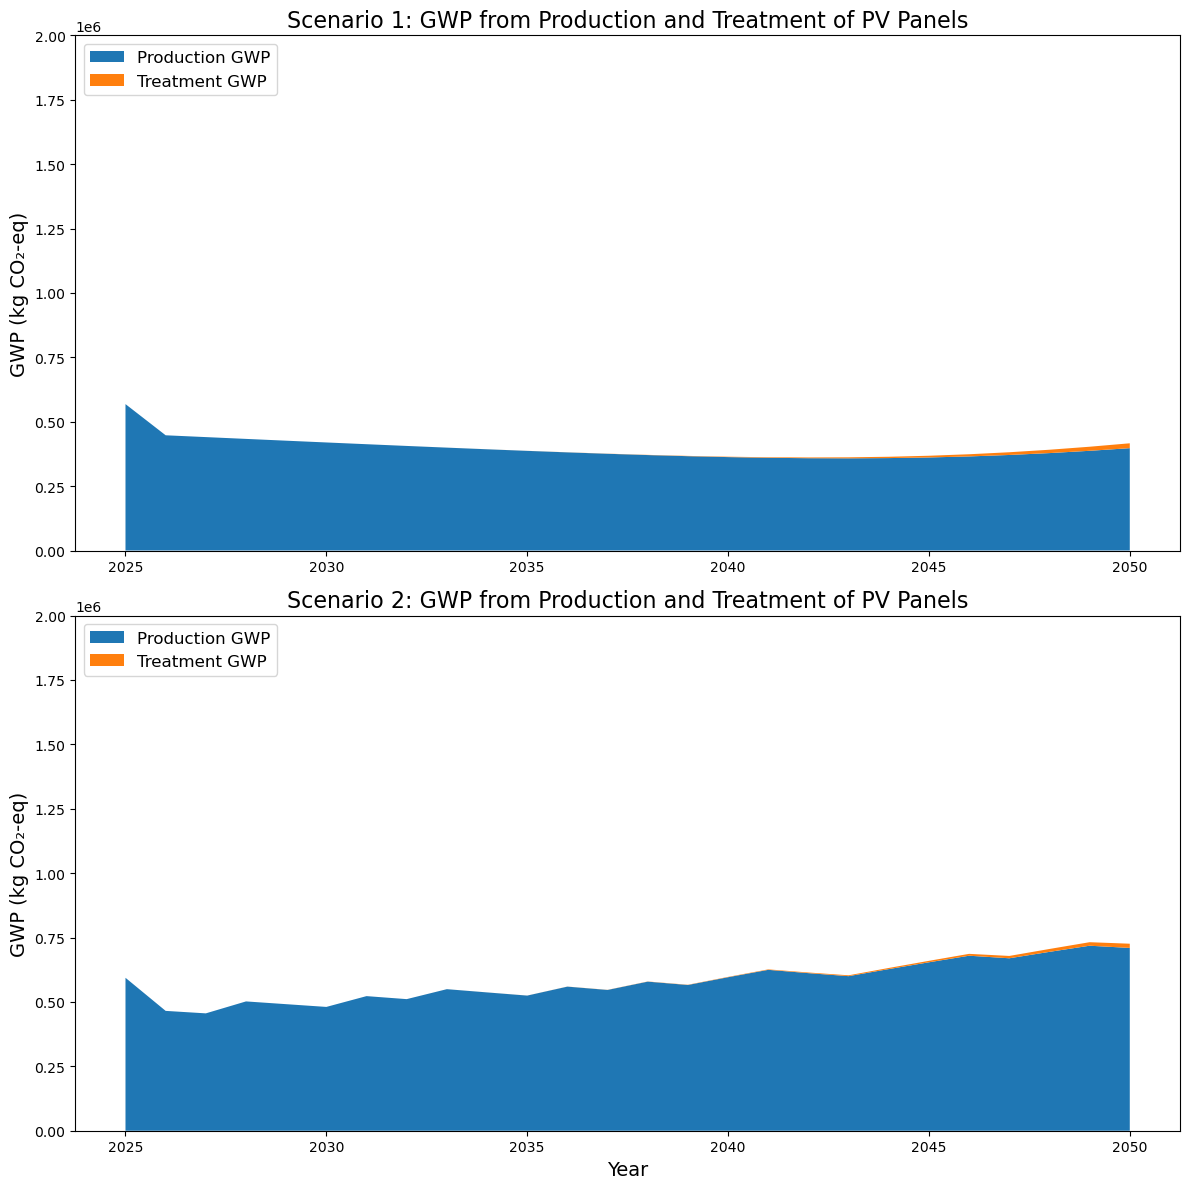

In [64]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Scenario 1 plot (Production and Treatment GWP)
axs[0].stackplot(
    years, 
    inflow_gwp_scenario_1, 
    outflow_gwp_scenario_1, 
    labels=['Production GWP', 'Treatment GWP'], 
    colors=MyColorCycle[:2]
)
axs[0].set_title('Scenario 1: GWP from Production and Treatment of PV Panels', fontsize=16)
axs[0].set_ylabel('GWP (kg CO₂-eq)', fontsize=14)
axs[0].legend(loc='upper left', fontsize=12)
axs[0].set_ylim(0, 2e6)  # Set y-limits

# Scenario 2 plot (Production and Treatment GWP)
axs[1].stackplot(
    years, 
    inflow_gwp_scenario_2, 
    outflow_gwp_scenario_2, 
    labels=['Production GWP', 'Treatment GWP'], 
    colors=MyColorCycle[:2]
)
axs[1].set_title('Scenario 2: GWP from Production and Treatment of PV Panels', fontsize=16)
axs[1].set_xlabel('Year', fontsize=14)
axs[1].set_ylabel('GWP (kg CO₂-eq)', fontsize=14)
axs[1].legend(loc='upper left', fontsize=12)
axs[1].set_ylim(0, 2e6)  # Set y-limits

# Adjust layout and display plot
plt.tight_layout()
plt.show()


# Static vs Dynamic (GWP intensities)

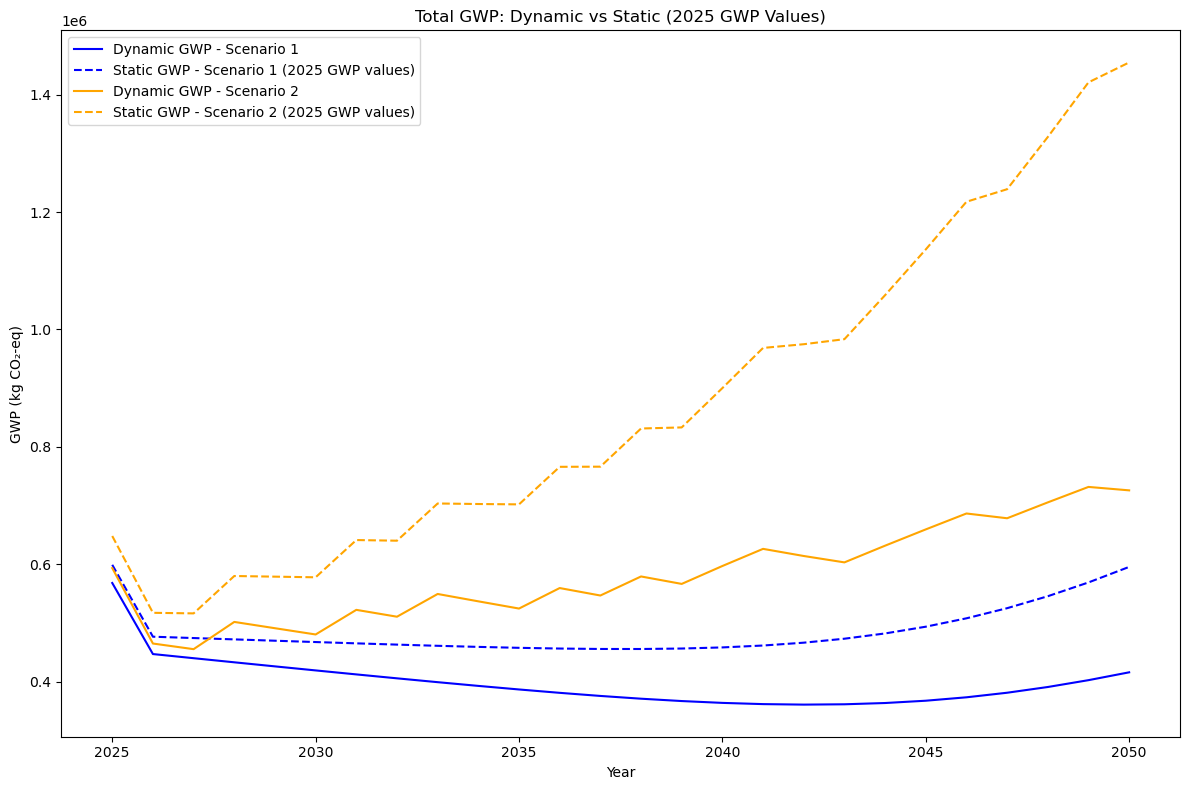

In [66]:
# Retrieve exact 2025 values from gwp_intensity_df for static calculations
production_gwp_2025_scenario_1 = gwp_intensity_df.loc[gwp_intensity_df['Year'] == 2020, 'PV module GWP - Scenario 1'].values[0]
treatment_gwp_2025_scenario_1 = gwp_intensity_df.loc[gwp_intensity_df['Year'] == 2020, 'Treatment GWP - Scenario 1'].values[0]
production_gwp_2025_scenario_2 = gwp_intensity_df.loc[gwp_intensity_df['Year'] == 2020, 'PV module GWP - Scenario 2'].values[0]
treatment_gwp_2025_scenario_2 = gwp_intensity_df.loc[gwp_intensity_df['Year'] == 2020, 'Treatment GWP - Scenario 2'].values[0]

# Initialize arrays for static GWP calculations using 2025 values
static_inflow_gwp_scenario_1 = []
static_inflow_gwp_scenario_2 = []
static_outflow_gwp_scenario_1 = []
static_outflow_gwp_scenario_2 = []

# Calculate GWP for inflows and outflows for each year using static 2025 values
for i in range(len(years)):
    # Scenario 1 - Static
    static_inflow_gwp_scenario_1.append(inflows[i, 0, 0] * production_gwp_2025_scenario_1)
    static_outflow_gwp_scenario_1.append(outflows[i, :, 0, 0].sum() * treatment_gwp_2025_scenario_1 * mass_per_square_meter)

    # Scenario 2 - Static
    static_inflow_gwp_scenario_2.append(inflows[i, 1, 0] * production_gwp_2025_scenario_2)
    static_outflow_gwp_scenario_2.append(outflows[i, :, 1, 0].sum() * treatment_gwp_2025_scenario_2 * mass_per_square_meter)

# Convert lists to arrays for plotting
static_total_gwp_scenario_1 = np.array(static_inflow_gwp_scenario_1) + np.array(static_outflow_gwp_scenario_1)
static_total_gwp_scenario_2 = np.array(static_inflow_gwp_scenario_2) + np.array(static_outflow_gwp_scenario_2)

# Use existing dynamic values
inflow_gwp_scenario_1 = np.array(inflow_gwp_scenario_1)
outflow_gwp_scenario_1 = np.array(outflow_gwp_scenario_1)
inflow_gwp_scenario_2 = np.array(inflow_gwp_scenario_2)
outflow_gwp_scenario_2 = np.array(outflow_gwp_scenario_2)
dynamic_total_gwp_scenario_1 = inflow_gwp_scenario_1 + outflow_gwp_scenario_1
dynamic_total_gwp_scenario_2 = inflow_gwp_scenario_2 + outflow_gwp_scenario_2

# Plot the dynamic vs static comparison for total GWP
fig, ax = plt.subplots(figsize=(12, 8))

# Scenario 1 plot
ax.plot(years, dynamic_total_gwp_scenario_1, label='Dynamic GWP - Scenario 1', linestyle='-', color='blue')
ax.plot(years, static_total_gwp_scenario_1, label='Static GWP - Scenario 1 (2025 GWP values)', linestyle='--', color='blue')

# Scenario 2 plot
ax.plot(years, dynamic_total_gwp_scenario_2, label='Dynamic GWP - Scenario 2', linestyle='-', color='orange')
ax.plot(years, static_total_gwp_scenario_2, label='Static GWP - Scenario 2 (2025 GWP values)', linestyle='--', color='orange')

# Formatting the plot
ax.set_title('Total GWP: Dynamic vs Static (2025 GWP Values)')
ax.set_xlabel('Year')
ax.set_ylabel('GWP (kg CO₂-eq)')
ax.legend()
plt.tight_layout()
plt.show()


# **Any thoughts?**